This is a script to explore resilience measures in SuperMAG data (i.e., time series)

The purpose is to test indicators of resilience and loss of resilience in time series data as popularized by Marten Scheffer

Exciting research points to the existence of generic properties (and the way that they can be measured) for systems near critical transitions [Scheffer et al., 2009](https://www.nature.com/articles/nature08227)
- Critical slowing down \cite{Wissel2004AUL}: As the system approaches such critical points, it becomes increasingly slow in recovering from small perturbations. In these regimes, the dynamical system will show an increase in lag-1 autocorrelation and increased variance in the pattern of fluctuations as the recovery rate from a small perturbation is reduced; 
- Skewness and flickering before transitions: Asymmetry in fluctuations increase near a critical transition. Flickering is indicated in the frequency distribution of states as increased variance and skewness as well as bimodality \cite{Carpenter2006RisingVA}; and
- (to be tested with imagery data) Increased spatial coherence: An analog to critical slowing down for spatial data, it has been shown that systems nearing critical transitions exhibit increased spatial correlation \cite{Dakos2010SpatialCA}. In systems consisting of numerous coupled units, slowing down near a critical transition will equalize differences between the units as each will tend to take the state of the units to which it is connected. 



Questions I'm exploring
- over what time period prior to the critical transition (i.e., substorm) is there indication of resilience loss in magnetometer/geomagnetic data? 
- ...
- how robust are these resilience findings to the choice of substorm event DB? 
- 

Open questions for these analyses
- What length of the time series is meaningful for computing the critical slowing down measures?
- What constitutes the 'during substorm' phase? 
- Do I need to only look at isolated substorms? Perhaps there is a list of isolated substorms (or a procedure in literature) or perhaps I could use SME to determine if the substorm emerged into already disturbed conditions, which would convolve the critical slowing down statistics I'm attempting to establish
    - choose a clear isolated substorm event to explore in depth first
- How long is the 'after substorm' phase? Should I use SME to determine that period?     
    

Assumptions we are making
- the identification of the substorm onset marks the first appearance of the substorm in the system and therefore everything that precedes that instant is 'pre-substorm'
- 



Time Series analyses - To Do
- DONE Get SuperMAG API working
- DONE Download substorms events list
- DONE Get the time series before and after the substorm event 
    - How will we choose what SuperMAG stations to obtain data for? Some threshold MLAT/MLT distance from the onset location? 
- Get the same number of time series samples randomly selected (control group) 
- Analyze the characteristics of those time series
    - How to form these characterizations? *working on this*
- Determine what is 'before' 'during' and 'after' a substorm (review how these substorm lists were compiled) 
- 
    
    


## Dependencies

In [217]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import supermag_api

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.signal import welch
from scipy.stats import skew

from statsmodels.tsa.ar_model import AutoReg


In [226]:

# Function to determine the number of header lines in the substorm ascii file
def count_header_lines(file_path):
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if line.startswith('<year>'):
                return i
            
# Define a function to combine the date and time columns into a datetime object
def combine_datetime(row):
    return datetime(row['<year>'], row['<month>'], row['<day>'], row['<hour>'], row['<min>'])

# for checking closeness in MLT
def is_close_to_target(current_time, target_time, tolerance_hours):
    
    # Calculate absolute differences considering both direct and wrapped-around distances
    time_difference1 = abs(current_time - target_time)
    time_difference2 = abs((current_time + 24) - target_time)
    time_difference3 = abs((current_time) - (target_time+24))
    
    # Check if either difference is within tolerance
    return time_difference1 <= tolerance_hours or time_difference2 <= tolerance_hours or time_difference3 <= tolerance_hours

def make_polar_plot(lat_substorm,lt_substorm,lat_station,lt_station):
    '''
        lat must be in degrees
        lt must be in hours
        they can be either scalars or vectors
        
    '''
    
    theta_substorm = (lt_substorm) * (2 * np.pi / 24)
    theta_station = (lt_station) * (2 * np.pi / 24)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    # Plot the point(s) 
    ax.plot(theta_substorm, 90-lat_substorm, 'o','r',)#
    substorm_label=f'Lat: {lat_substorm} deg, Time: {lt_substorm}'
    ax.scatter(theta_station, 90-lat_station,c='b',alpha=0.5)# label=f'Lat: {lat}°, Time: {lt}:00')

    # define your axis limits
    ax.set_ylim([0,45])

    # Set the radius labels
    ax.set_yticks(np.arange(0,50,10))  # less radial ticks
    ax.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

    # Set the circumference labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
    ax.set_xticklabels(('0','6','12','18'))      
    # Make the labels go clockwise
    # ax.set_theta_direction(-1)

    ax.grid(True)
    ax.set_theta_zero_location("S")

    # Add grid lines for better readability
    ax.grid(True)
    plt.title('Substorm onset: '+substorm_label)
    plt.show()
    return



def plot_mag_timeseries(sm_data,substorm_datetime,station_id):
    # sample call: plot_mag_timeseries(sm_data,df_substorms_2003.index[substorm_event_id], stations[i])

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=sm_data['datetime'], 
        y=sm_data['N nez'], 
        mode='lines', 
        name='N'
    ))

    fig.add_trace(go.Scatter(
        x=sm_data['datetime'], 
        y=sm_data['E nez'], 
        mode='lines', 
        name='E'
    ))

    fig.add_trace(go.Scatter(
        x=sm_data['datetime'], 
        y=sm_data['Z nez'], 
        mode='lines', 
        name='Z'
    ))


    # Add a vertical black bar at time of substorm
    fig.add_shape(
        type="line",
        x0=substorm_datetime, x1=substorm_datetime,  # specify the date for the vertical line
        y0=sm_data['N nez'].min(), y1=sm_data['N nez'].max(),
        line=dict(color="White", width=2)
    )

    fig.update_layout(
        title='Station '+stations[i],
        xaxis_title='Date',
        yaxis_title='Magnetic Perturbations',
        template='plotly_dark'  # Optional: choose a theme
    )

    fig.show()
    

def calculate_variance(window):
    return np.nanvar(window)

def calculate_return_rate(window):
    try:
        model = AutoReg(window, lags=1, old_names=False)
        model_fit = model.fit()
        return model_fit.params[1]  # Return the autoregressive coefficient
    except:
        return np.nan

def calculate_skewness(window):
    return skew(window, nan_policy='omit')


def calculate_early_warning_indicators(time_series, window_size=30):
    
    '''
    Early Warning Indicators: Use established methods to detect CSD, such as:
        - Variance Increase: Rising variance as a system approaches a critical threshold.
        - Autocorrelation Increase: Rising autocorrelation at lag-1 as an indicator of CSD.
        - Skewness and Kurtosis: Changes in skewness and kurtosis as potential signals.
    
    
    
    '''
    variance_list = []
    return_rate_list = []
    skewness_list = []

    for i in range(len(time_series)):
        if i < window_size:
            variance_list.append(np.nan)
            return_rate_list.append(np.nan)
            skewness_list.append(np.nan)
            continue
        
        window = time_series[i-window_size:i]
        
        # Check for NaN percentage
        if np.isnan(window).sum() > 0.2 * window_size:
            variance_list.append(np.nan)
            return_rate_list.append(np.nan)
            skewness_list.append(np.nan)
            continue
        
        # Calculate metrics
        variance_list.append(calculate_variance(window))
        return_rate_list.append(calculate_return_rate(window))
        skewness_list.append(calculate_skewness(window))
    
    return pd.DataFrame({
                            'Variance': variance_list,
                            'Return_Rate': return_rate_list,
                            'Skewness': skewness_list
                        })

    
def plot_csd_indicators(sm_data,csd_indicators_df_N,csd_indicators_df_E,csd_indicators_df_Z,substorm_datetime):
    
    # Create subplots
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)

    # Add time series to the first panel
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_N['Variance'], mode='lines', name='N'), row=1, col=1)
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_E['Variance'], mode='lines', name='E'), row=1, col=1)
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_Z['Variance'], mode='lines', name='Z'), row=1, col=1)
    
    # Add a vertical black bar at time of substorm
    fig.add_shape(
        type="line",
        x0=substorm_datetime, x1=substorm_datetime,  # specify the date for the vertical line
        y0=csd_indicators_df_N['Variance'].min(), y1=csd_indicators_df_N['Variance'].max(),
        line=dict(color="White", width=2),
        row=1, col=1)

    # Add time series to the second panel
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_N['Return_Rate'], mode='lines', name='N'), row=2, col=1)
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_E['Return_Rate'], mode='lines', name='E'), row=2, col=1)
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_Z['Return_Rate'], mode='lines', name='Z'), row=2, col=1)
    
    # Add a vertical black bar at time of substorm
    fig.add_shape(
        type="line",
        x0=substorm_datetime, x1=substorm_datetime,  # specify the date for the vertical line
        y0=csd_indicators_df_N['Return_Rate'].min(), y1=csd_indicators_df_N['Return_Rate'].max(),
        line=dict(color="White", width=2),
        row=2, col=1)
    
    # Add time series to the third panel
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_N['Skewness'], mode='lines', name='N'), row=3, col=1)
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_E['Skewness'], mode='lines', name='E'), row=3, col=1)
    fig.add_trace(go.Scatter(x=sm_data['datetime'], y=csd_indicators_df_Z['Skewness'], mode='lines', name='Z'), row=3, col=1)
    
    # Add a vertical black bar at time of substorm
    fig.add_shape(
        type="line",
        x0=substorm_datetime, x1=substorm_datetime,  # specify the date for the vertical line
        y0=csd_indicators_df_N['Skewness'].min(), y1=csd_indicators_df_N['Skewness'].max(),
        line=dict(color="White", width=2),
        row=3, col=1)
    
    # Update layout to link x-axes
    fig.update_xaxes(matches='x')

    # Update layout with titles and axis labels
    fig.update_layout(
        title='Critical Slowing Down Indicators, Station '+stations[i],
        height=900,
        showlegend=False,
        template='plotly_dark'  # Optional: choose a theme
    )
    
    # Label the y-axes of each subplot
    fig.update_yaxes(title_text="Variance", row=1, col=1)
    fig.update_yaxes(title_text="Return Rate", row=2, col=1)
    fig.update_yaxes(title_text="Skewness", row=3, col=1)


    # Show the figure
    fig.show()


In [44]:
file_location = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/supermag_data/'
supermag_userid = 'rymc1012'

## Read in substorms

In [25]:
# Newell and Gjerloev, 2011 substorms list
substorms_file_name = os.path.join(file_location,'substorms-newell-19700101_000000_to_20240102_000000.ascii')

header_lines = count_header_lines(substorms_file_name)

# Read the data into a DataFrame, skipping the first 7 lines (header)
df_substorms = pd.read_csv(substorms_file_name, delim_whitespace=True, skiprows=header_lines)

# Rename columns to remove angle brackets
df_substorms.columns = df_substorms.columns.str.strip('<>')

# Combine the date and time columns into a datetime object
df_substorms['datetime'] = pd.to_datetime(df_substorms[['year', 'month', 'day', 'hour', 'min']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H-%M')

# Set the datetime column as the index
df_substorms.set_index('datetime', inplace=True)

# Drop the original date and time columns

df_substorms.drop(columns=['year', 'month', 'day', 'hour', 'min'], inplace=True)


print(df_substorms.head())

                       mlt   mlat    glon   glat
datetime                                        
1976-01-01 01:44:00  23.54  76.85  306.47  69.25
1976-01-01 10:59:00  23.09  69.72  203.38  71.32
1976-01-02 08:17:00   1.72  69.86  265.91  58.76
1976-01-03 11:10:00   4.65  69.86  265.91  58.76
1976-01-03 11:45:00   5.28  69.86  265.91  58.76


In [26]:
df_substorms

mlt   mlat    glon   glat
datetime                                        
1976-01-01 01:44:00  23.54  76.85  306.47  69.25
1976-01-01 10:59:00  23.09  69.72  203.38  71.32
1976-01-02 08:17:00   1.72  69.86  265.91  58.76
1976-01-03 11:10:00   4.65  69.86  265.91  58.76
1976-01-03 11:45:00   5.28  69.86  265.91  58.76
...                    ...    ...     ...    ...
2023-07-25 23:19:00  23.04  65.01  338.30  64.18
2023-07-26 01:39:00   1.26  65.01  338.30  64.18
2023-07-26 04:56:00   4.44  65.01  338.30  64.18
2023-07-26 22:48:00  22.53  65.01  338.30  64.18
2023-07-29 00:11:00  23.87  65.01  338.30  64.18

[81914 rows x 4 columns]

In [30]:

# Count the number of rows for each year
yearly_counts = df_substorms.resample('Y').size()

print(yearly_counts)


datetime
1976-12-31    1274
1977-12-31     965
1978-12-31    1225
1979-12-31    1296
1980-12-31     825
1981-12-31    1401
1982-12-31    2426
1983-12-31    2413
1984-12-31    2523
1985-12-31    1717
1986-12-31    1573
1987-12-31    1474
1988-12-31    1516
1989-12-31    2029
1990-12-31    1777
1991-12-31    2510
1992-12-31    1892
1993-12-31    2109
1994-12-31    3056
1995-12-31    1968
1996-12-31    1745
1997-12-31    1423
1998-12-31    1922
1999-12-31    2120
2000-12-31    2047
2001-12-31    1568
2002-12-31    1936
2003-12-31    3637
2004-12-31    2159
2005-12-31    2303
2006-12-31    1569
2007-12-31    1493
2008-12-31    1396
2009-12-31     514
2010-12-31    1048
2011-12-31    1161
2012-12-31    1473
2013-12-31    1201
2014-12-31    1228
2015-12-31    2076
2016-12-31    2089
2017-12-31    2273
2018-12-31    1404
2019-12-31    1216
2020-12-31    1028
2021-12-31    1325
2022-12-31    1796
2023-12-31     795
Freq: A-DEC, dtype: int64


In [203]:
year_analyze = '2017' #'2003'
df_substorms = df_substorms.loc[year_analyze]

In [204]:
df_substorms

mlt   mlat    glon   glat
datetime                                        
2017-01-01 01:08:00  22.56  67.41  310.32  62.00
2017-01-01 01:37:00  22.96  71.43  307.10  65.42
2017-01-01 05:04:00  17.63  70.87  211.21  70.36
2017-01-01 09:21:00  22.50  67.65  214.78  66.56
2017-01-01 09:47:00  22.06  65.59  199.56  66.97
...                    ...    ...     ...    ...
2017-12-29 19:10:00  23.66  67.35   66.83  71.16
2017-12-30 03:06:00   0.66  69.98  308.27  64.17
2017-12-30 18:56:00   0.30  69.34   80.70  73.53
2017-12-30 21:43:00  23.72  71.89   19.20  74.50
2017-12-31 21:09:00   1.18  65.95   61.21  69.60

[2273 rows x 4 columns]

## Get the supermag station data to test for resilience measures around the substorm critical transition

Questions to answer
- what time resolution do we need to witness critical slowing down? 
- what span of time might we expect to see the change in the time series preceding the critical transition? How much data to grab for each event? 

0.81

In [207]:
# setting constraints on the data to explore
mlat_bounds = 10. # +/- in degree latitude
mlt_bounds = 4. # +/- in hours local time
time_series_bounds = 2. # +/- in hours

substorm_event_id = 0
substorm_event = df_substorms.iloc[substorm_event_id]

# get all SuperMag data for the day of the event


In [208]:
substorm_event

mlt      22.56
mlat     67.41
glon    310.32
glat     62.00
Name: 2017-01-01 01:08:00, dtype: float64

In [209]:
df_substorms.index[substorm_event_id]  - timedelta(hours=time_series_bounds)


Timestamp('2016-12-31 23:08:00')

working on station = A02
working on station = A03
working on station = A08
working on station = A09
working on station = A10
working on station = ABG
working on station = AIA
working on station = AMS
working on station = AND
working on station = API
working on station = ARS
working on station = ASC
working on station = ASP
working on station = ATU
	 keeping station with MLAT,MLT = 73.989975,22.488134 and substorm MLAT,MLT =67.41,22.56


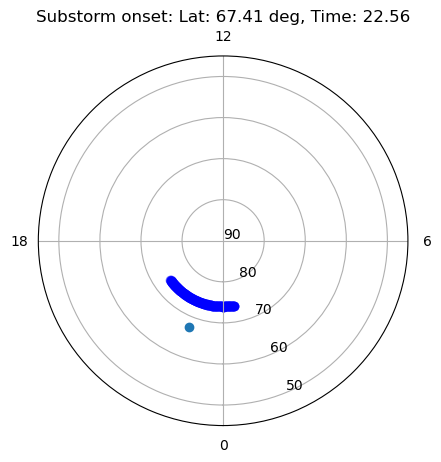

press any key to continue...
working on station = BDV
working on station = BEL
working on station = BEY
working on station = BFE
working on station = BFO
working on station = BJN
working on station = BMT
working on station = BOU
working on station = BOX
working on station = BRD
working on station = BRW
working on station = BSL
working on station = C13
working on station = CAN
working on station = CBB
working on station = CDC
	 keeping station with MLAT,MLT = 73.469017,20.144869 and substorm MLAT,MLT =67.41,22.56


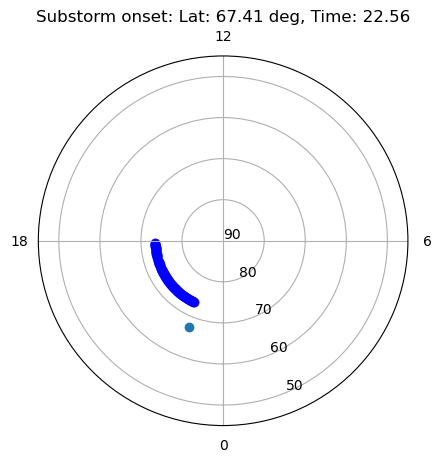

press any key to continue...
working on station = CKI
working on station = CLF
working on station = CMO
working on station = CNB
working on station = CSY
working on station = CYG
working on station = CZT
working on station = DED
working on station = DIK
working on station = DMC
working on station = DMH
	 keeping station with MLAT,MLT = 77.33667,1.567545 and substorm MLAT,MLT =67.41,22.56


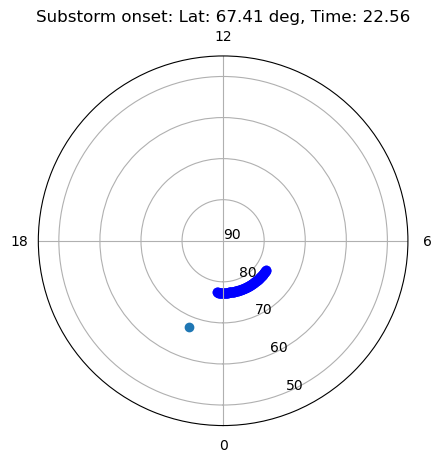

press any key to continue...
working on station = DOB
	 keeping station with MLAT,MLT = 59.638481,1.954417 and substorm MLAT,MLT =67.41,22.56


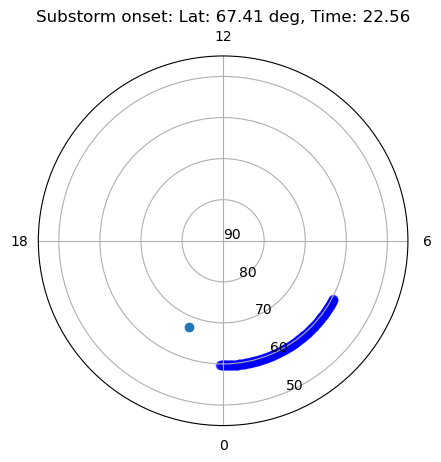

press any key to continue...
working on station = DON
	 keeping station with MLAT,MLT = 63.753826,2.28839 and substorm MLAT,MLT =67.41,22.56


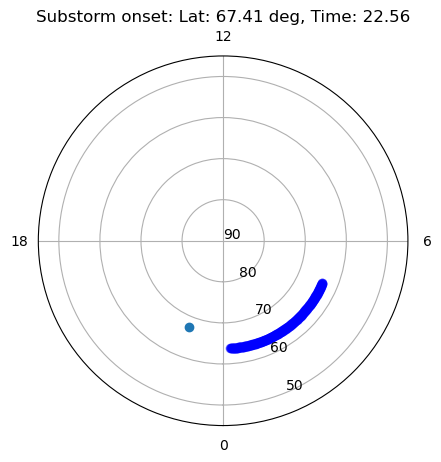

press any key to continue...
working on station = DRV
working on station = EBR
working on station = ESK
working on station = EYR
working on station = FCC
working on station = FHB
	 keeping station with MLAT,MLT = 67.412025,22.545059 and substorm MLAT,MLT =67.41,22.56


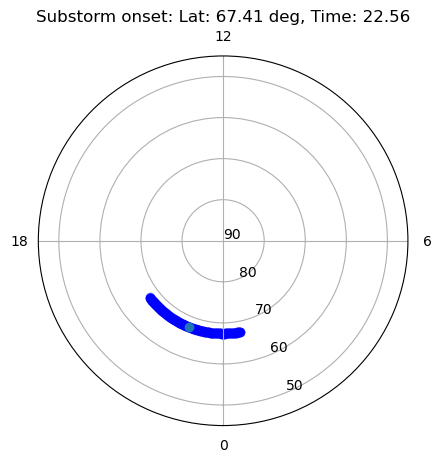

press any key to continue...
working on station = FRD
working on station = FRN
working on station = FUR
working on station = FYU
working on station = GAN
working on station = GDH
	 keeping station with MLAT,MLT = 75.248413,22.567802 and substorm MLAT,MLT =67.41,22.56


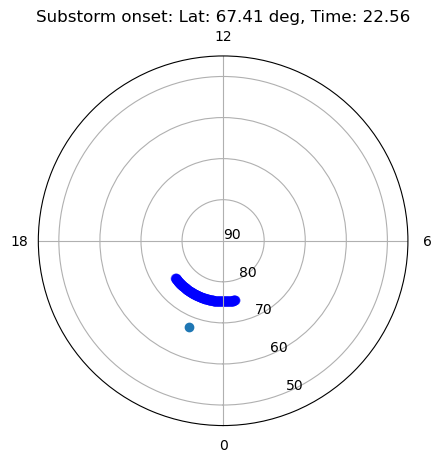

press any key to continue...
working on station = GHC
working on station = GNG
working on station = GUA
working on station = GUI
working on station = HAD
working on station = HAN
working on station = HBK
working on station = HER
working on station = HLP
working on station = HON
working on station = HOP
working on station = HOV
	 keeping station with MLAT,MLT = 60.257954,1.087146 and substorm MLAT,MLT =67.41,22.56


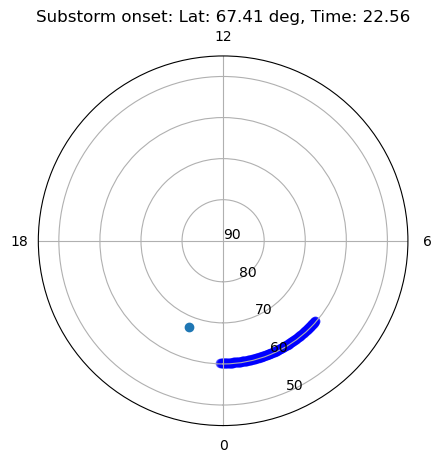

press any key to continue...
working on station = HRB
working on station = HRN
working on station = HUA
working on station = IPM
working on station = IQA
	 keeping station with MLAT,MLT = 72.20977,20.980734 and substorm MLAT,MLT =67.41,22.56


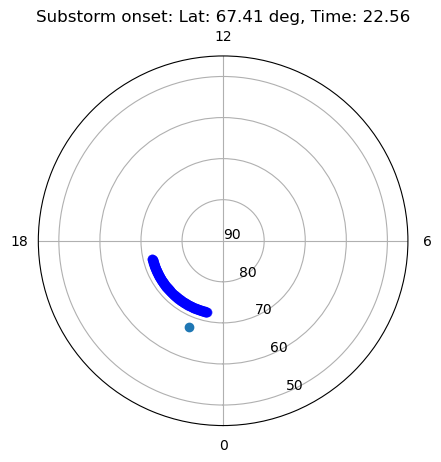

press any key to continue...
working on station = IRT
working on station = IVA
working on station = JAI
working on station = JAN
	 keeping station with MLAT,MLT = 70.473801,1.460523 and substorm MLAT,MLT =67.41,22.56


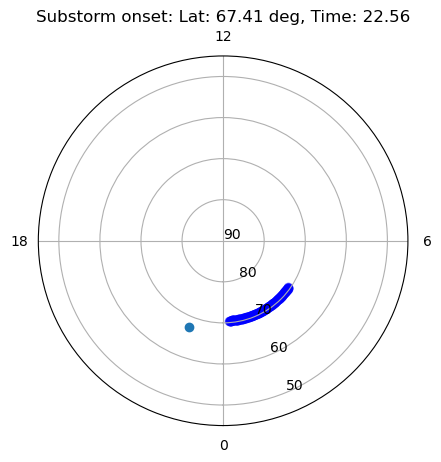

In [ ]:
event_starttime = df_substorms.index[substorm_event_id] - timedelta(hours=time_series_bounds)

(status,stations) = supermag_api.SuperMAGGetInventory(supermag_userid,
                                                      event_starttime,
                                                      time_series_bounds*3600*2)
# print(stations)
flags = 'mlt,mag'
station_list_event = []
for i in range(len(stations)-1):
    print('working on station = {}'.format(stations[i]))
    (status,sm_data)=supermag_api.SuperMAGGetData(supermag_userid,
                                     event_starttime,
                                     time_series_bounds*3600*2,
                                     flags,stations[i])
    # convert tval to datetime
    sm_data['datetime'] = pd.to_datetime(sm_data['tval'], unit='s')

    # find the datetime closest to the substorm onset
    closest_index = (sm_data['datetime'] - df_substorms.index[substorm_event_id]).abs().idxmin()
    
    # 


    if ( (sm_data.iloc[closest_index].mlat > (substorm_event.mlat-mlat_bounds) ) & 
         (sm_data.iloc[closest_index].mlat < (substorm_event.mlat+mlat_bounds) )  ):
        if is_close_to_target(sm_data.iloc[closest_index].mlt, substorm_event.mlt, mlt_bounds):
            station_list_event.append(stations[i])
            print('\t keeping station with MLAT,MLT = {},{} and substorm MLAT,MLT ={},{}'.format(sm_data.iloc[closest_index].mlat,
                                                                                                 sm_data.iloc[closest_index].mlt,
                                                                                                 substorm_event.mlat,
                                                                                                 substorm_event.mlt))
            
            # plot location of onset and the station's data
            make_polar_plot(substorm_event.mlat,substorm_event.mlt,sm_data.mlat.values,sm_data.mlt.values)

            # ------ Process and store the time series data in a large dataframe ------
            #  Right now, just visualizing and pausing the loop to inspect
            
            # clean and normalize(?) the data
            
            
            sm_data['N nez'] = [item['nez'] for item in sm_data['N']]
            sm_data['E nez'] = [item['nez'] for item in sm_data['E']]
            sm_data['Z nez'] = [item['nez'] for item in sm_data['Z']]
            sm_data.replace(999999.0, np.nan, inplace=True)
            
            # (potentially) create flags for before, during, and after the substorm
            
            # calculate the early warning indicators
            csd_indicators_df_N = calculate_early_warning_indicators(sm_data['N nez'])
            csd_indicators_df_E = calculate_early_warning_indicators(sm_data['E nez'])
            csd_indicators_df_Z = calculate_early_warning_indicators(sm_data['Z nez'])
            
            
            #-------------------------------------------------------------------------------------
            # Plot
            plot_mag_timeseries(sm_data,df_substorms.index[substorm_event_id], stations[i])
            plot_csd_indicators(sm_data,csd_indicators_df_N,csd_indicators_df_E,csd_indicators_df_Z,df_substorms.index[substorm_event_id])
            
            input('press any key to continue...')
            #-------------------------------------------------------------------------------------

            
        else:
            continue

In [ ]:
# plot_mag_timeseries(sm_data,df_substorms.index[substorm_event_id], stations[i])
# plot_csd_indicators(sm_data,csd_indicators_df_N,csd_indicators_df_E,csd_indicators_df_Z,df_substorms.index[substorm_event_id])


In [170]:
(status,sm_data)=supermag_api.SuperMAGGetData(supermag_userid,
                                     event_starttime,
                                     time_series_bounds*3600*2,
                                     flags,stations[i])

In [172]:
sm_data


tval   ext iaga        mlon       mlat       mlt     mcolat  \
0    1.041384e+09  60.0  BJN  107.875702  71.504639  3.264489  18.495361   
1    1.041384e+09  60.0  BJN  107.875702  71.504639  3.282309  18.495361   
2    1.041384e+09  60.0  BJN  107.875702  71.504639  3.300146  18.495361   
3    1.041384e+09  60.0  BJN  107.875702  71.504639  3.318000  18.495361   
4    1.041384e+09  60.0  BJN  107.875694  71.504639  3.335870  18.495361   
..            ...   ...  ...         ...        ...       ...        ...   
235  1.041398e+09  60.0  BJN  107.875641  71.504639  7.551610  18.495361   
236  1.041398e+09  60.0  BJN  107.875641  71.504639  7.570190  18.495361   
237  1.041398e+09  60.0  BJN  107.875641  71.504639  7.588780  18.495361   
238  1.041398e+09  60.0  BJN  107.875641  71.504639  7.607378  18.495361   
239  1.041398e+09  60.0  BJN  107.875641  71.504639  7.625985  18.495361   

                                         N  \
0     {'nez': 17.254303, 'geo': 16.153498}   
1     {'nez': 15.366074, 'geo': 14.279706}   
2     {'nez': 13.482731, 'geo': 12.706463}   
3     {'nez': 12.593407, 'geo': 11.824825}   
4      {'nez': 10.702089, 'geo': 9.652074}   
..                                     ...   
235     {'nez': 0.742102, 'geo': 0.866132}   
236     {'nez': -1.388912, 'geo': -1.5496}   
237   {'nez': -4.516947, 'geo': -4.364521}   
238  {'nez': -9.660769, 'geo': -11.250653}   
239   {'nez': -2.815468, 'geo': -5.636165}   

                                        E  \
0     {'nez': 8.764098, 'geo': 10.657621}   
1     {'nez': 8.743353, 'geo': 10.423648}   
2      {'nez': 6.105736, 'geo': 7.590115}   
3      {'nez': 6.088116, 'geo': 7.472119}   
4      {'nez': 8.685984, 'geo': 9.839639}   
..                                    ...   
235  {'nez': -1.139703, 'geo': -1.048548}   
236    {'nez': 1.500779, 'geo': 1.334224}   
237  {'nez': -1.092916, 'geo': -1.596317}   
238  {'nez': 14.617718, 'geo': 13.432458}   
239  {'nez': 25.122162, 'geo': 24.643123}   

                                          Z  
0        {'nez': 6.623582, 'geo': 6.623582}  
1        {'nez': 3.615177, 'geo': 3.615177}  
2        {'nez': 1.606438, 'geo': 1.606438}  
3        {'nez': -1.40255, 'geo': -1.40255}  
4      {'nez': -2.411715, 'geo': -2.411715}  
..                                      ...  
235  {'nez': -17.499676, 'geo': -17.499676}  
236  {'nez': -10.459824, 'geo': -10.459824}  
237    {'nez': -7.421453, 'geo': -7.421453}  
238    {'nez': -2.384476, 'geo': -2.384476}  
239    {'nez': -4.348878, 'geo': -4.348878}  

[240 rows x 10 columns]

## Get the data for the relevant stations and plot the time series


In [176]:
sm_data['N nez'] = [item['nez'] for item in sm_data['N']]
sm_data['E nez'] = [item['nez'] for item in sm_data['E']]
sm_data['Z nez'] = [item['nez'] for item in sm_data['Z']]
sm_data.replace(999999.0, np.nan, inplace=True)




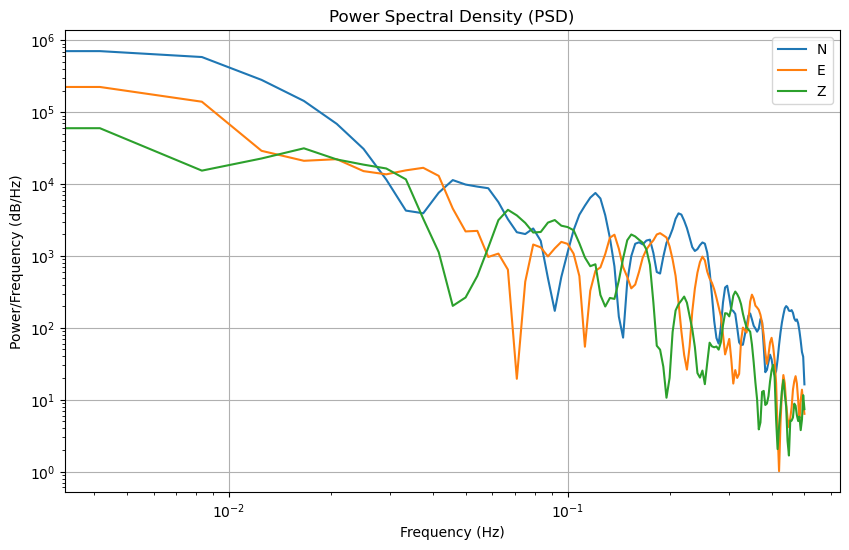

In [181]:
# Compute the Power Spectral Density using the Welch method
freqs_N, psd_N = welch(sm_data['N nez'])
freqs_E, psd_E = welch(sm_data['E nez'])
freqs_Z, psd_Z = welch(sm_data['Z nez'])


# Plot the PSD
plt.figure(figsize=(10, 6))
# plt.semilogy(freqs_N, psd_N,label='N')
# plt.semilogy(freqs_E, psd_E,label='E')
# plt.semilogy(freqs_Z, psd_Z,label='Z')
plt.loglog(freqs_N, psd_N,label='N')
plt.loglog(freqs_E, psd_E,label='E')
plt.loglog(freqs_Z, psd_Z,label='Z')
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)

